# Машинное обучение для текстов

Интернет-магазин «Викишоп» запускает новый сервис. 
Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. 
То есть клиенты предлагают свои правки и комментируют изменения других. 
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача**: обучить модель классифицировать комментарии на позитивные и негативные, используя набор данных с разметкой о токсичности правок.

Нужна модель со значением метрики качества *F1* не меньше 0.75. 

**Шаги**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.


## Модуди и параметры

In [1]:
from math import ceil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import re
#import nltk
#import pymorphy2
from tqdm import notebook
import gensim
#from pymystem3 import Mystem

import torch
import transformers 
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /home/sergey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/sergey/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/sergey/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [2]:
RANDOM_STATE = 42

## Функции для сохранения и загрузки переменных
Будем сохранять результаты длинных этапов.

In [3]:
import pickle

def save_var(
    var, 
    fname
):
    with open(f'{fname}.pickle', 'wb') as f:
        pickle.dump(var, f)


def load_var(
    fname
):
    with open(f'{fname}.pickle', 'rb') as f:
        var = pickle.load(f)
    return var

## Подготовка

### Заргрузка данных

In [4]:
toxic_comments = pd.read_csv('toxic_comments.csv', index_col=[0])

print(toxic_comments.shape)
display(toxic_comments.dtypes)
toxic_comments.head()

(159292, 2)


text     object
toxic     int64
dtype: object

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Всё загрузилось ок

In [5]:
toxic_comments['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

Выборка не очень сбаласированная - токсичных комментариев около 10%

### Пропуски и дубликаты

In [6]:
toxic_comments.isna().sum()

text     0
toxic    0
dtype: int64

In [7]:
toxic_comments.duplicated().sum()

0

In [8]:
toxic_comments.duplicated(subset=['text']).sum()

0

Пропусков нет, одинаковых отзывов тоже

In [9]:
toxic_comments_train, toxic_comments_test = train_test_split(
    toxic_comments,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=toxic_comments.toxic
)
print(
    toxic_comments.shape, '->',
    toxic_comments_train.shape, '+',
    toxic_comments_test.shape
)

(159292, 2) -> (127433, 2) + (31859, 2)


### TF-IDF

In [10]:
# Загрузим набор английских стоп-слов
stopwords = nltk.corpus.stopwords.words("english")
stopword_set = set(stopwords)

In [11]:
# Создадим функцию для лемматизации

wnl = WordNetLemmatizer()

def lemmatize(sent):

    text = ' '.join(
        re.findall(
            "[abcdefghijklmnopqrstuvwxyz]+", 
            sent.lower()
        )
    )
    
    res = []
    for word, tag in nltk.pos_tag(nltk.word_tokenize(text)):
        wntag = tag[0].lower()
        word = word.lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        if not wntag:
            lemma = word
        else:
            lemma = wnl.lemmatize(word, wntag)
        res.append(lemma)
    return ' '.join(res)

In [12]:
%%time

fname = 'toxic_comments_test_text_lemm'
try:
    toxic_comments_test_text_lemm = load_var(fname)
except:
    toxic_comments_test_text_lemm = [lemmatize(sent) for sent in toxic_comments_test['text']]
    save_var(toxic_comments_test_text_lemm, fname)

fname = 'toxic_comments_train_text_lemm'
try:
    toxic_comments_train_text_lemm = load_var(fname)
except:
    toxic_comments_train_text_lemm = [lemmatize(sent) for sent in toxic_comments_train['text']]
    save_var(toxic_comments_train_text_lemm, fname)

CPU times: user 13 ms, sys: 32.9 ms, total: 45.9 ms
Wall time: 45.5 ms


In [13]:
# TF-IDF преобразование
count_tf_idf = TfidfVectorizer(stop_words=stopwords, max_features=200)

tf_idf = count_tf_idf.fit_transform(toxic_comments_train_text_lemm)
tf_idf_train = pd.DataFrame(tf_idf.toarray(), columns = ['tf_idf_' + str(num) for num in range(tf_idf.shape[1])])

tf_idf = count_tf_idf.transform(toxic_comments_test_text_lemm)
tf_idf_test = pd.DataFrame(tf_idf.toarray(), columns = ['tf_idf_' + str(num) for num in range(tf_idf.shape[1])])

In [14]:
print(toxic_comments_train.shape, tf_idf_train.shape)

toxic_comments_train_tf_idf = pd.concat(
    [
        toxic_comments_train.reset_index(drop=True),
        tf_idf_train
    ], 
    axis=1
)
print(toxic_comments_train_tf_idf.shape)

toxic_comments_train_tf_idf.head()

(127433, 2) (127433, 200)
(127433, 202)


,text,toxic,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,...,tf_idf_190,tf_idf_191,tf_idf_192,tf_idf_193,tf_idf_194,tf_idf_195,tf_idf_196,tf_idf_197,tf_idf_198,tf_idf_199
0,It's been nearly two months and you still have...,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,I'm withdrawing my support. I do not support W...,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.476496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,What is this all about? The day before yesterd...,0,0.0,0.0,0.0,0.0,0.212928,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"""\na """"demon-possessed pedophile"""" [pedophile ...",1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,you are abusing your position as admin to trol...,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
print(toxic_comments_test.shape, tf_idf_test.shape)

toxic_comments_test_tf_idf = pd.concat(
    [
        toxic_comments_test.reset_index(drop=True),
        tf_idf_test
    ], 
    axis=1
)
print(toxic_comments_test_tf_idf.shape)

toxic_comments_test_tf_idf.head()

(31859, 2) (31859, 200)
(31859, 202)


,text,toxic,tf_idf_0,tf_idf_1,tf_idf_2,tf_idf_3,tf_idf_4,tf_idf_5,tf_idf_6,tf_idf_7,...,tf_idf_190,tf_idf_191,tf_idf_192,tf_idf_193,tf_idf_194,tf_idf_195,tf_idf_196,tf_idf_197,tf_idf_198,tf_idf_199
0,Your mum is a big fat whore.\nYour mum is a bi...,1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,I have restored the information arbitrarily de...,0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.245291,0.0,0.000000,0.272238,0.175245,0.475908,0.0,0.0,0.0
2,"""\n\nVandalism\n Please stop. If you continue ...",0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.222532,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,"""\n\n language \n\nSome noteworthy (and quite ...",0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.473576,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,Please feel free to add anything you feel I've...,0,0.0,0.0,0.276339,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


Признаки силами TF-IDF готовы, можно использовать их для обучения

### word2vec

In [16]:
# w2v модель
fname = 'w2v_model'

try:
    w2v_model = load_var(fname)
    
except:
    vector_size = 200
    sg = 0
    window = 5
    min_count = 5
    negative = 20
    epochs = 30
    
    w2v_model = gensim.models.Word2Vec(
        vector_size=vector_size, 
        sg=sg, 
        window=window, 
        min_count=min_count, 
        negative=negative
    )
    
    w2v_model.build_vocab(toxic_comments_train_text_lemm)
    
    w2v_model.train(
        toxic_comments_train_text_lemm, 
        total_examples=w2v_model.corpus_count, 
        epochs=epochs
    )
    
    save_var(w2v_model, fname)

In [17]:
# Преобразуем тексты из датасета в новые колонки с w2v-признаками.
def text_to_embeddings(
    text,
    word2index,
    word_embeddings
):
    embs = np.array([word_embeddings[word2index[word]] for word in text if word in word2index])
    
    if embs.shape[0] > 0:
        return embs.mean(0, keepdims=True)
    else:
        return np.zeros((1, word_embeddings.shape[1]))

In [18]:
%%time
text2vec = np.concatenate(
    [text_to_embeddings(text, w2v_model.wv.key_to_index, w2v_model.wv.vectors) for text in toxic_comments_train_text_lemm]
)
w2v_train = pd.DataFrame(text2vec, columns = ['w2v_' + str(num) for num in range(text2vec.shape[1])])

text2vec = np.concatenate(
    [text_to_embeddings(text, w2v_model.wv.key_to_index, w2v_model.wv.vectors) for text in toxic_comments_test_text_lemm]
)
w2v_test = pd.DataFrame(text2vec, columns = ['w2v_' + str(num) for num in range(text2vec.shape[1])])

CPU times: user 21.8 s, sys: 33.2 ms, total: 21.8 s
Wall time: 21.8 s


In [19]:
print(toxic_comments_train.shape, w2v_train.shape)

toxic_comments_train_w2v = pd.concat(
    [
        toxic_comments_train.reset_index(drop=True),
        w2v_train
    ], 
    axis=1
)
print(toxic_comments_train_w2v.shape)

toxic_comments_train_w2v.head()

(127433, 2) (127433, 200)
(127433, 202)


,text,toxic,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,...,w2v_190,w2v_191,w2v_192,w2v_193,w2v_194,w2v_195,w2v_196,w2v_197,w2v_198,w2v_199
0,It's been nearly two months and you still have...,0,0.052825,-0.017680,0.043906,0.022902,0.102825,0.056007,-0.027123,0.040877,...,-0.144517,0.123805,-0.030851,0.205362,0.021456,-0.087091,0.141583,0.475179,0.126730,0.026523
1,I'm withdrawing my support. I do not support W...,0,-0.041115,-0.035729,0.078544,-0.035480,0.005899,0.083344,-0.050793,0.056089,...,-0.162002,0.058946,-0.069107,0.134609,0.008450,-0.021789,0.099951,0.377000,0.135013,0.106304
2,What is this all about? The day before yesterd...,0,0.092731,-0.039929,0.025923,0.007301,0.065754,0.083741,-0.014410,0.063507,...,-0.145131,0.080394,-0.071438,0.168011,0.049557,-0.048743,0.160177,0.431319,0.133913,0.090779
3,"""\na """"demon-possessed pedophile"""" [pedophile ...",1,-0.133029,0.002527,0.065272,-0.020531,0.065601,0.026991,-0.084504,0.077449,...,-0.205519,0.048323,-0.049009,0.145677,0.016717,-0.030657,0.173991,0.445208,0.216428,0.116171
4,you are abusing your position as admin to trol...,0,0.155141,-0.028870,-0.029818,0.035744,0.116420,0.071787,0.007331,0.057311,...,-0.152129,0.070804,-0.028019,0.186005,0.026560,-0.040617,0.204334,0.402159,0.112494,0.086436


In [20]:
print(toxic_comments_test.shape, w2v_test.shape)

toxic_comments_test_w2v = pd.concat(
    [
        toxic_comments_test.reset_index(drop=True),
        w2v_test
    ], 
    axis=1
)
print(toxic_comments_test_w2v.shape)

toxic_comments_test_w2v.head()

(31859, 2) (31859, 200)
(31859, 202)


,text,toxic,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,...,w2v_190,w2v_191,w2v_192,w2v_193,w2v_194,w2v_195,w2v_196,w2v_197,w2v_198,w2v_199
0,Your mum is a big fat whore.\nYour mum is a bi...,1,0.218991,-0.029848,0.016238,-0.035244,0.000004,0.161144,0.071755,0.032788,...,-0.105810,0.119834,-0.075278,0.055185,-0.044152,0.014227,0.185238,0.313592,-0.053001,0.223816
1,I have restored the information arbitrarily de...,0,0.086601,-0.023820,0.030856,-0.009969,0.030705,0.067882,-0.014509,0.028532,...,-0.162811,0.072975,-0.048262,0.162066,0.043332,-0.031960,0.185960,0.402101,0.128926,0.096001
2,"""\n\nVandalism\n Please stop. If you continue ...",0,0.036104,-0.013813,0.041911,0.036192,0.055334,0.135280,-0.020197,0.101042,...,-0.148735,0.024842,-0.074007,0.136360,-0.080127,-0.075908,0.163367,0.256200,0.055273,0.200291
3,"""\n\n language \n\nSome noteworthy (and quite ...",0,-0.028194,0.004651,0.060793,-0.043893,0.067759,0.083872,-0.047660,0.023582,...,-0.158177,0.125092,-0.027326,0.157321,0.000807,-0.048012,0.135532,0.430565,0.109808,0.097540
4,Please feel free to add anything you feel I've...,0,0.119199,-0.012599,-0.012417,0.009773,0.055106,0.045619,-0.005574,0.037918,...,-0.143451,0.084212,-0.088230,0.158904,0.069546,-0.056380,0.206226,0.449794,0.161010,0.136101


Признаки силами word2vec готовы, можно использовать их для обучения

### BERT

In [21]:
# Используем готовую модель
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

model = model.to(device)

In [22]:
tokenized_train = toxic_comments_train['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

tokenized_test = toxic_comments_test['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True)
)

max_len = max(tokenized_train.apply(len).max(), tokenized_test.apply(len).max())

print(max_len)

padded = {}
padded['train'] = np.array([i + [0] * (max_len - len(i)) for i in tokenized_train.values])
padded['test'] = np.array([i + [0] * (max_len - len(i)) for i in tokenized_test.values])

attention_mask = {}
attention_mask['train'] = np.where(padded['train'] != 0, 1, 0)
attention_mask['test'] = np.where(padded['test'] != 0, 1, 0)

512


In [23]:
# преобразуем 
bert_data = {}

for name in ['test', 'train']:

    fname = 'bert_' + name

    try:
        tmp = load_var(fname)
        bert_data[name] = tmp
    except:
        batch_size = 200
        embeddings = []
        for i in notebook.tqdm(range(ceil(padded[name].shape[0] / batch_size))):
            batch = torch.LongTensor(padded[name][batch_size * i: batch_size * (i + 1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[name][batch_size * i: batch_size * (i + 1)])
        
            with torch.no_grad():
                batch_embeddings = model(
                    batch.to(device), 
                    attention_mask=attention_mask_batch.to(device)
                )
        
            embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

        features = np.concatenate(embeddings)
        tmp = pd.DataFrame(features, columns = ['bert_' + str(num) for num in range(features.shape[1])])
        bert_data[name] = tmp
        save_var(tmp, fname)

In [24]:
print(toxic_comments_train.shape, bert_data['train'].shape)

toxic_comments_train_bert = pd.concat(
    [
        toxic_comments_train.reset_index(drop=True),
        bert_data['train']
    ], 
    axis=1
)
print(toxic_comments_train_bert.shape)

toxic_comments_train_bert.head()

(127433, 2) (127433, 768)
(127433, 770)


,text,toxic,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,It's been nearly two months and you still have...,0,-0.447427,-0.740811,0.602709,-0.415123,1.035598,0.357524,0.561516,-0.070529,...,-0.422968,-1.089249,0.305164,-0.648013,0.106829,0.459913,-0.535086,-0.488526,0.547356,0.154771
1,I'm withdrawing my support. I do not support W...,0,-0.756514,-1.007813,0.458320,-0.677197,1.096403,0.286492,0.122068,0.024610,...,-0.494178,-0.936869,0.447919,-0.660790,0.189538,0.780960,-0.250507,-0.705991,0.504578,0.318040
2,What is this all about? The day before yesterd...,0,-0.322874,-0.767167,0.954478,-0.099938,0.803701,0.262967,0.547981,0.584910,...,-0.775164,-0.314199,0.360958,-0.727613,-0.435773,0.000189,-0.458777,-0.288952,0.603387,0.777611
3,"""\na """"demon-possessed pedophile"""" [pedophile ...",1,-0.459568,-0.558006,0.589342,-0.054478,0.026913,0.494088,0.605422,0.874161,...,-0.776550,0.355965,-0.408197,-0.941726,-0.258191,-0.184802,-0.172370,-0.298244,0.549522,0.878904
4,you are abusing your position as admin to trol...,0,-0.504579,-0.639117,0.745477,-0.573602,1.249181,0.393469,0.426723,-0.078967,...,-0.689282,-0.893915,0.445104,-0.689777,-0.000308,0.566151,-0.465642,-0.738819,0.700347,0.389182


In [25]:
print(toxic_comments_test.shape, bert_data['test'].shape)

toxic_comments_test_bert = pd.concat(
    [
        toxic_comments_test.reset_index(drop=True),
        bert_data['test']
    ], 
    axis=1
)
print(toxic_comments_test_bert.shape)

toxic_comments_test_bert.head()

(31859, 2) (31859, 768)
(31859, 770)


,text,toxic,bert_0,bert_1,bert_2,bert_3,bert_4,bert_5,bert_6,bert_7,...,bert_758,bert_759,bert_760,bert_761,bert_762,bert_763,bert_764,bert_765,bert_766,bert_767
0,Your mum is a big fat whore.\nYour mum is a bi...,1,-0.055677,0.730127,0.552857,0.218202,-0.498195,0.784403,0.406365,0.157261,...,-1.226346,1.081991,-0.937633,-0.467165,-0.761481,-1.448738,-0.071755,-0.490737,-0.461577,-0.343633
1,I have restored the information arbitrarily de...,0,-0.703614,-0.904728,0.335976,-0.603784,0.898249,0.256695,-0.149098,0.031022,...,-0.557954,-1.244908,0.313116,-0.606124,0.281862,0.879834,-0.655300,-0.825394,0.347111,0.097552
2,"""\n\nVandalism\n Please stop. If you continue ...",0,-0.744458,-0.959014,0.146565,-0.763488,1.199084,0.620545,0.324232,0.141364,...,-0.493961,-0.890076,0.342825,-0.764426,0.259035,0.791086,-0.434975,-0.920202,0.132829,0.432873
3,"""\n\n language \n\nSome noteworthy (and quite ...",0,-0.709178,-0.993490,0.307458,-0.433907,0.976940,0.335193,-0.207499,0.058960,...,-0.525576,-1.191123,0.151339,-0.712628,0.232816,1.046304,-0.600414,-0.797348,0.304566,0.062759
4,Please feel free to add anything you feel I've...,0,-0.455759,-0.702340,0.582235,-0.397650,0.948862,0.082592,-0.216039,0.151921,...,-0.397813,-1.189315,0.406362,-0.519145,0.230543,0.826328,-0.382177,-0.846871,0.382146,0.230640


Признаки силами BERT готовы, можно использовать их для обучения

### WordCloud

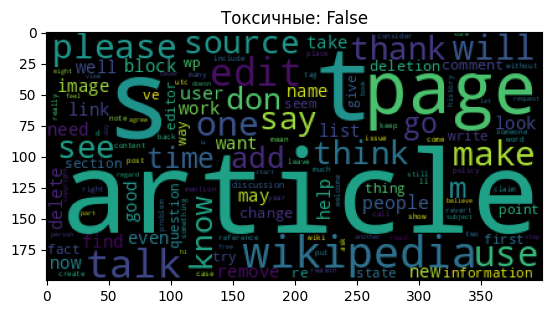

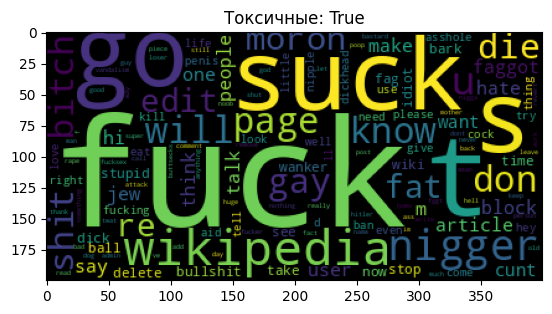

In [26]:
tmp = pd.DataFrame()
tmp['toxic'] = toxic_comments_train['toxic']
tmp['text'] = toxic_comments_train_text_lemm

for toxic in [0, 1]:
    text_raw = ' '.join(tmp.loc[tmp.toxic == toxic, 'text'].values)
    wordcloud = WordCloud(collocations=False).generate(text_raw)
    plt.imshow(wordcloud)
    plt.title(f'Токсичные: {bool(toxic)}')
    plt.show()

## Обучение

In [27]:
results = {}

In [28]:
pipe = Pipeline(
    [
        ('model', DummyClassifier())
    ]
)

In [29]:
param_grid = [
    
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE, max_iter=300)]
    },
    
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [6, 8]
    },
    
    {
        'model': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)],
        'model__depth': [6, 8]
    },
    
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': [6, 8]
    },
    
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)],
        'model__max_depth': [6, 8]
    }
]

### TF-IDF

In [30]:
X_train = toxic_comments_train_tf_idf.loc[:, toxic_comments_train_tf_idf.columns.str.contains('tf_idf_')]
y_train = toxic_comments_train_tf_idf['toxic']

X_test = toxic_comments_test_tf_idf.loc[:, toxic_comments_test_tf_idf.columns.str.contains('tf_idf_')]
y_test = toxic_comments_test_tf_idf['toxic']

In [31]:
grid_tf_idf = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=1
)

In [32]:
fname = 'grid_tf_idf'

try:
    grid_tf_idf = load_var(fname)
except:
    grid_tf_idf.fit(X_train, y_train)
    save_var(grid_tf_idf, fname)

In [33]:
results['TF-IDF'] = pd.DataFrame(grid_tf_idf.cv_results_).sort_values(by='rank_test_score').head(20)
results['TF-IDF']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,44.133085,0.166822,0.022104,0.000551,<catboost.core.CatBoostClassifier object at 0x...,NaN,8.0,{'model': <catboost.core.CatBoostClassifier ob...,0.450963,0.424876,0.435512,0.425754,0.440128,0.435447,0.009678,1
3,17.935188,0.104574,0.021473,0.000593,<catboost.core.CatBoostClassifier object at 0x...,NaN,6.0,{'model': <catboost.core.CatBoostClassifier ob...,0.442575,0.419630,0.430076,0.427281,0.436279,0.431168,0.007819,2
6,4.011116,0.241430,0.044258,0.001226,"XGBClassifier(base_score=None, booster=None, c...",8.0,NaN,"{'model': XGBClassifier(base_score=None, boost...",0.448295,0.413165,0.429155,0.419193,0.436533,0.429268,0.012455,3
0,0.452733,0.054713,0.008423,0.000663,"LogisticRegression(max_iter=300, random_state=42)",NaN,NaN,"{'model': LogisticRegression(max_iter=300, ran...",0.447005,0.422137,0.427196,0.419383,0.426588,0.428462,0.009709,4
5,3.206201,0.174241,0.033978,0.002563,"XGBClassifier(base_score=None, booster=None, c...",6.0,NaN,"{'model': XGBClassifier(base_score=None, boost...",0.434503,0.413467,0.421986,0.422386,0.432321,0.424933,0.007652,5
8,0.573619,0.013617,0.017846,0.000551,"LGBMClassifier(random_state=42, verbosity=-1)",8.0,NaN,"{'model': LGBMClassifier(random_state=42, verb...",0.427804,0.406401,0.416390,0.404488,0.422035,0.415424,0.008932,6
7,0.534210,0.018720,0.018089,0.001540,"LGBMClassifier(random_state=42, verbosity=-1)",6.0,NaN,"{'model': LGBMClassifier(random_state=42, verb...",0.426230,0.403275,0.412852,0.405233,0.414420,0.412402,0.008126,7
2,1.235491,0.005155,0.008989,0.000318,DecisionTreeClassifier(random_state=42),8.0,NaN,{'model': DecisionTreeClassifier(random_state=...,0.412899,0.402034,0.408860,0.396489,0.401829,0.404422,0.005778,8
1,0.944445,0.005918,0.009373,0.000744,DecisionTreeClassifier(random_state=42),6.0,NaN,{'model': DecisionTreeClassifier(random_state=...,0.405841,0.405952,0.389778,0.400607,0.401961,0.400828,0.005913,9


In [34]:
print(f'f1 на обучающей: {grid_tf_idf.best_score_:.3f}')

f1 на обучающей: 0.435


In [35]:
y_test_pred = grid_tf_idf.predict(X_test)
f1_test_tf_idf = f1_score(y_test, y_test_pred)
print(f'f1 на тестовой: {f1_test_tf_idf:.3f}')

f1 на тестовой: 0.427


### word2vec

In [36]:
X_train = toxic_comments_train_w2v.loc[:, toxic_comments_train_w2v.columns.str.contains('w2v_')]
y_train = toxic_comments_train_w2v['toxic']

X_test = toxic_comments_test_w2v.loc[:, toxic_comments_test_w2v.columns.str.contains('w2v_')]
y_test = toxic_comments_test_w2v['toxic']

In [37]:
grid_w2v = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=1
)

In [38]:
fname = 'grid_w2v'

try:
    grid_w2v = load_var(fname)
except:
    grid_w2v.fit(X_train, y_train)
    save_var(grid_w2v, fname)

In [39]:
results['word2vec'] = pd.DataFrame(grid_w2v.cv_results_).sort_values(by='rank_test_score').head(20)
results['word2vec']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,10.956689,0.091896,0.047190,0.000546,"XGBClassifier(base_score=None, booster=None, c...",8.0,NaN,"{'model': XGBClassifier(base_score=None, boost...",0.360987,0.354078,0.347654,0.357163,0.332391,0.350455,0.010032,1
3,18.404799,0.092382,0.076007,0.108223,<catboost.core.CatBoostClassifier object at 0x...,NaN,6.0,{'model': <catboost.core.CatBoostClassifier ob...,0.357666,0.350118,0.344848,0.352246,0.340438,0.349063,0.005957,2
5,5.604663,0.062732,0.036646,0.002919,"XGBClassifier(base_score=None, booster=None, c...",6.0,NaN,"{'model': XGBClassifier(base_score=None, boost...",0.354766,0.355226,0.341729,0.351931,0.339255,0.348581,0.006746,3
4,46.774569,0.141199,0.024110,0.001483,<catboost.core.CatBoostClassifier object at 0x...,NaN,8.0,{'model': <catboost.core.CatBoostClassifier ob...,0.353218,0.343470,0.339094,0.354543,0.339567,0.345978,0.006642,4
7,1.887532,0.090403,0.022028,0.001227,"LGBMClassifier(random_state=42, verbosity=-1)",6.0,NaN,"{'model': LGBMClassifier(random_state=42, verb...",0.325511,0.320244,0.320024,0.321483,0.316904,0.320833,0.002784,5
8,1.906821,0.038838,0.020260,0.000236,"LGBMClassifier(random_state=42, verbosity=-1)",8.0,NaN,"{'model': LGBMClassifier(random_state=42, verb...",0.318375,0.319491,0.312805,0.323833,0.310774,0.317055,0.004714,6
2,17.028556,0.185767,0.010284,0.000545,DecisionTreeClassifier(random_state=42),8.0,NaN,{'model': DecisionTreeClassifier(random_state=...,0.286804,0.296014,0.287387,0.273056,0.283725,0.285397,0.007399,7
1,13.224199,0.203563,0.009988,0.000409,DecisionTreeClassifier(random_state=42),6.0,NaN,{'model': DecisionTreeClassifier(random_state=...,0.280774,0.289830,0.302207,0.253416,0.233577,0.271961,0.025016,8
0,0.879438,0.140293,0.008029,0.001120,"LogisticRegression(max_iter=300, random_state=42)",NaN,NaN,"{'model': LogisticRegression(max_iter=300, ran...",0.220934,0.239262,0.234131,0.238020,0.221367,0.230743,0.008014,9


In [40]:
print(f'f1 на обучающей: {grid_w2v.best_score_:.3f}')

f1 на обучающей: 0.350


In [41]:
y_test_pred = grid_w2v.predict(X_test)
f1_test_w2v = f1_score(y_test, y_test_pred)
print(f'f1 на тестовой: {f1_test_w2v:.3f}')

f1 на тестовой: 0.364


### BERT

In [42]:
X_train = toxic_comments_train_bert.loc[:, toxic_comments_train_bert.columns.str.contains('bert_')]
y_train = toxic_comments_train_bert['toxic']

X_test = toxic_comments_test_bert.loc[:, toxic_comments_test_bert.columns.str.contains('bert_')]
y_test = toxic_comments_test_bert['toxic']

In [43]:
grid_bert = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='f1',
    n_jobs=1
)

In [44]:
fname = 'grid_bert'

try:
    grid_bert = load_var(fname)
except:
    grid_bert.fit(X_train, y_train)
    save_var(grid_bert, fname)

In [45]:
results['BERT'] = pd.DataFrame(grid_bert.cv_results_).sort_values(by='rank_test_score').head(20)
results['BERT']

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__max_depth,param_model__depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.534908,0.432369,0.058884,0.007593,"LogisticRegression(max_iter=300, random_state=42)",NaN,NaN,"{'model': LogisticRegression(max_iter=300, ran...",0.944133,0.944046,0.948970,0.944888,0.950510,0.946510,0.002698,1
4,147.979728,0.196913,0.051186,0.002484,<catboost.core.CatBoostClassifier object at 0x...,NaN,8.0,{'model': <catboost.core.CatBoostClassifier ob...,0.942957,0.946129,0.947368,0.946961,0.947490,0.946181,0.001681,2
3,57.448513,0.397104,0.048443,0.001929,<catboost.core.CatBoostClassifier object at 0x...,NaN,6.0,{'model': <catboost.core.CatBoostClassifier ob...,0.941633,0.945131,0.946071,0.945925,0.948885,0.945529,0.002326,3
8,7.768169,0.108303,0.023500,0.001545,"LGBMClassifier(random_state=42, verbosity=-1)",8.0,NaN,"{'model': LGBMClassifier(random_state=42, verb...",0.942021,0.944123,0.946882,0.947084,0.947247,0.945471,0.002072,4
7,7.505102,0.258902,0.024619,0.001989,"LGBMClassifier(random_state=42, verbosity=-1)",6.0,NaN,"{'model': LGBMClassifier(random_state=42, verb...",0.943433,0.943578,0.944776,0.946615,0.947368,0.945154,0.001589,5
6,28.655845,0.419148,0.090459,0.005629,"XGBClassifier(base_score=None, booster=None, c...",8.0,NaN,"{'model': XGBClassifier(base_score=None, boost...",0.943140,0.943938,0.943127,0.945469,0.945889,0.944312,0.001161,6
5,22.559631,0.445042,0.076077,0.002621,"XGBClassifier(base_score=None, booster=None, c...",6.0,NaN,"{'model': XGBClassifier(base_score=None, boost...",0.942088,0.942769,0.944123,0.945412,0.945546,0.943988,0.001383,7
1,51.557675,0.486623,0.010623,0.000256,DecisionTreeClassifier(random_state=42),6.0,NaN,{'model': DecisionTreeClassifier(random_state=...,0.930260,0.934287,0.933435,0.930413,0.935428,0.932765,0.002082,8
2,68.427599,0.809647,0.010860,0.000488,DecisionTreeClassifier(random_state=42),8.0,NaN,{'model': DecisionTreeClassifier(random_state=...,0.925268,0.930512,0.928022,0.927230,0.928807,0.927968,0.001733,9


In [46]:
print(f'f1 на обучающей: {grid_bert.best_score_:.3f}')

f1 на обучающей: 0.947


In [47]:
y_test_pred = grid_bert.predict(X_test)
f1_test_bert = f1_score(y_test, y_test_pred)
print(f'f1 на тестовой: {f1_test_bert:.3f}')

f1 на тестовой: 0.947


## Выводы

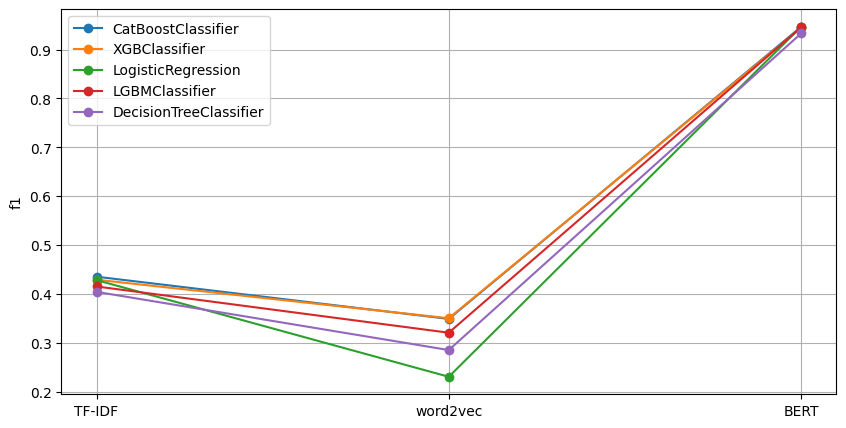

In [48]:
# немножно упражнений в коде, чтобы нарисовать сводный график
def model_name(
    s
):
    s = str(s)
    if 'Logistic' in s:
        return 'LogisticRegression'
    if 'CatBoost' in s:
        return 'CatBoostClassifier'
    if 'DecisionTree' in s:
        return 'DecisionTreeClassifier'
    if 'XGB' in s:
        return 'XGBClassifier'
    if 'LGBM' in s:
        return 'LGBMClassifier'
    return ''

metrics_dict = {}

for key, val in results.items():    
    names = val.param_model.apply(lambda x: model_name(x)).values
    metrics = val.mean_test_score.values

    # только лучший результат для модели
    tmp = {}
    for n, m in zip(names, metrics):
        if n not in tmp:
            tmp[n] = m

    # лучшую в словарь metrics_dict
    for k, v in tmp.items():
        if k not in metrics_dict:
            metrics_dict[k] = [v]
        else:
            metrics_dict[k].append(v)

plt.figure(figsize=(10, 5))
for key, val in metrics_dict.items():
    plt.plot(results.keys(), val, 'o-', label=key)
plt.ylabel('f1')
plt.legend()
plt.grid()
plt.show()

Опробованы 3 варианта кодирования текстов:
* TF-IDF
* word2vec
* BERT

Для каждого с помощью GridSearchCV выявлена лучшая модель. В первых двух вариантах лучше всего показала себя CatBoostClassifier, в последнем неожиданно LogisticRegression слегка опередила CatBoostClassifier .

Хуже всех себя показала word2vec, TF-IDF чуть лучше, но только BERT позволяет для всех моделей получить целевое значение метрики